# Coordinates retrieving of the closest image in the database - Training

Workflow:

* encoding images using transfert learning from pretrained ResNet model on a geographic zones classification task
* binary hash images of training images in 512 feature space
* retrieving the closest image to the one to identify in that feature space using Locality Sensitive Hashing for fast approximate nearest neighbor

Paper decribing Binary Hashing method: https://www.cv-foundation.org/openaccess/content_cvpr_workshops_2015/W03/papers/Lin_Deep_Learning_of_2015_CVPR_paper.pdf

### To set up environment

In [1]:
########################################
######## Packages to install ###########
########################################

####========install open cv===============
# !pip install opencv-python

####========install pytorch===============
# !pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

####========install adabound=============
#####adabound is an optimizer for pytorch based a combinaison of Adam and SGD optimizer
#####for more informations see https://github.com/Luolc/AdaBound
# !pip install adabound

####========install lshash - for python3===============
# !pip install lshash3

### Imports

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import multiprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from tqdm import notebook
import cv2 as cv
import os
from skimage import transform
import pickle
import random

from lshash.lshash import LSHash

import torch
from torchvision import models, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
# from torch.optim import Adam

import adabound as adabound

In [3]:
#import from local scripts 
from Custom_dataloader_geozones import MapDataset, Rescale, SquareRescale, CenterCrop, Normalize, ToTensor
from geographic_zones import create_geo_zones, classify_geographic_zones

### Path variables

In [4]:
###Define path to train data
path_train_CSV_1 = "./data/piom_train_30k.csv"
path_train_CSV_2 = "./data/piom_train2_10k.csv"
path_train_image_folder_1 = './data/piom_train_png_30k/'
path_train_image_folder_2 = './data/piom_train2_png_10k/'

###Define path to models
path_CNN_to_save = './models/gpu_model_resnet18.pth'
path_LSH_to_save = './models/lsh.pkl'

### Util functions

Custom dataLoader and tensor tranform functions

In [5]:
###scipt imported from Custom_dataloader_geozones.py

# class MapDataset(Dataset):
#     def __init__(self, coordinateDf, root_dir, transform=None):
#         """
#         Args:
#             coordinateDf (pd.DataFrame): DataFrame with image id and geographic coordinates.
#             root_dir (string): Directory with all the images.
#             transform (callable, optional): Optional transform to be applied on a sample.
#         """
#         self.map_coordinates = coordinateDf
#         self.root_dir = root_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.map_coordinates)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
#         img_name = os.path.join(self.root_dir,
#                                 self.map_coordinates.iloc[idx, 0] + '.png')
#         image = cv.imread(img_name)
#         image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

#         if self.transform:
#             image = self.transform(image)
#         coordinates_crnr = np.array([self.map_coordinates['llcrnrlon'].iloc[idx], 
#                             self.map_coordinates['llcrnrlat'].iloc[idx],
#                             self.map_coordinates['urcrnrlon'].iloc[idx], 
#                             self.map_coordinates['urcrnrlat'].iloc[idx]]).astype('float')
#         sample = {'image': image,
#                   'Geo_zone': self.map_coordinates['Geo_zone'].iloc[idx],
#                   'image_path': img_name,
#                   'coordinates_crnr': coordinates_crnr}
#         return sample

# class Rescale(object):
#     """Rescale the image in a sample to a given size.

#     Args:
#         output_size (tuple or int): Desired output size. If tuple, output is
#             matched to output_size. If int, smaller of image edges is matched
#             to output_size keeping aspect ratio the same.
#     """

#     def __init__(self, output_size):
#         assert isinstance(output_size, (int, tuple))
#         self.output_size = output_size

#     def __call__(self, image):
#         h, w = image.shape[:2]
#         if isinstance(self.output_size, int):
#             if h > w:
#                 new_h, new_w = self.output_size * h / w, self.output_size 
#             else:
#                 new_h, new_w = self.output_size, self.output_size * w / h
#         else:
#             new_h, new_w = self.output_size
#         new_h, new_w = int(new_h), int(new_w)
#         # image = transform.resize(image, (new_h, new_w), mode='reflect', anti_aliasing=True)
#         image = cv.resize(image, (new_h, new_w))
#         return image

# class SquareRescale(object):
#     """Rescale the image in a sample to a given size."""

#     def __init__(self, output_size):
#         assert isinstance(output_size, (int, tuple))
#         self.output_size = output_size

#     def __call__(self, image):
#         image = cv.resize(image, (self.output_size, self.output_size))
#         # image = transform.resize(image, (self.output_size, self.output_size), mode='reflect', anti_aliasing=True)
#         return image


# class CenterCrop(object):
#     """Crop the image in a sample centered to the middle of the image."""

#     def __init__(self, output_size):
#         assert isinstance(output_size, (int, tuple))
#         if isinstance(output_size, int):
#             self.output_size = (output_size, output_size)
#         else:
#             assert len(output_size) == 2
#             self.output_size = output_size

#     def __call__(self, image):
#         h, w = image.shape[:2]
#         new_h, new_w = self.output_size
#         image = image[((h - new_h)//2): ((h - new_h)//2) + new_h,
#                       ((w - new_w)//2): ((w - new_w)//2) + new_w]
#         return image


# class Normalize(object):
#     """Normalize the image."""

#     def __init__(self, alpha, beta):
#         self.alpha = alpha
#         self.beta = beta

#     def __call__(self, image):
#         image = cv.normalize(image, None, alpha=self.alpha, beta=self.beta, 
#                     norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
#         return image


# class ToTensor(object):
#     """Convert ndarrays to torch tensors."""

#     def __call__(self, image):
#         # swap color axis because
#         # numpy image: H x W x C
#         # torch image: C X H X W
#         image = image.transpose((2, 0, 1))
#         return torch.from_numpy(image)

Functions to group samples in geographic zones based on their latitude and longitude coordinates

In [6]:
###scipt imported from geographic_zones.py

# def create_geo_zones(Lon, Lat, lon_dim=10, lat_dim=10):
#     """Define geographic zones given latitude and longitude distributions"""
#     zones =[] 
#     izone = 0
#     for index in range (len(Lon)):
#         zoneFound = False
#         for zone in zones:
#             if abs(zone[0]-Lon[index]) <= lon_dim and abs(zone[1]-Lat[index]) <= lat_dim:
#                 zoneFound = True
#                 break
#         if not zoneFound:
#             zones.append([Lon[index], Lat[index], izone])
#             izone += 1
#         # if (index+1) % 1000 == 0:
#         #     print('Creating zones: Row [{}/{}]'.format(index+1, len(Lon)), end="\r")
#     return zones

# def classify_geographic_zones(zones, row, lon_dim=10, lat_dim=10):
#     """Classify a point to a geographic zone"""
#     # min_dist = np.inf
#     for zone in zones:
#         if abs(zone[0]-row['llcrnrlon']) <= lon_dim and abs(zone[1]-row['llcrnrlat']) <= lat_dim:
#             return zone[2]
#         # tmp_min_dist = abs(zone[0]-row['llcrnrlon']) + abs(zone[1]-row['llcrnrlat'])
#         # if tmp_min_dist < min_dist:
#         #     min_dist = tmp_min_dist
#         #     zone_to_return = zone[2]
#     # return(zone_to_return)
#     print('Out of Zone')
#     return 0

### Training

Number of geographic zones:  496
Training geozone created, time: 0.0h, 0.0min, 53.71319532394409s


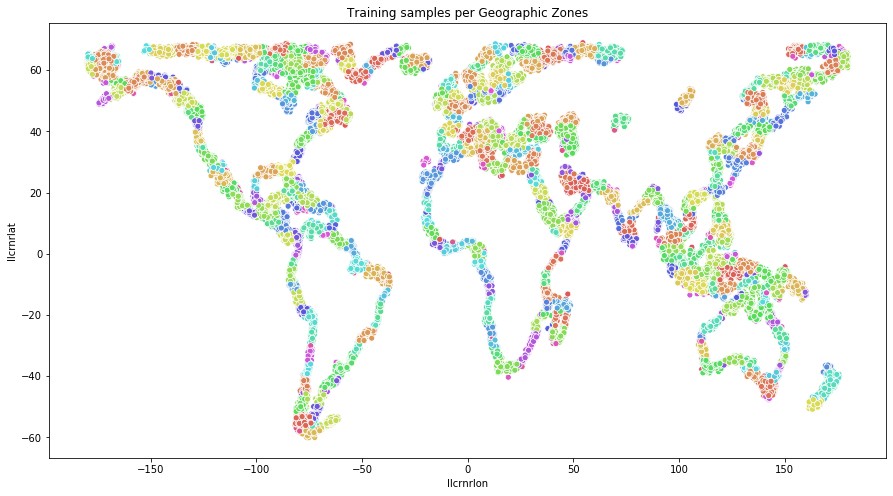

Train dataloader created, number of cores: 12
============ Training phase 1 - number of epochs: 2 ============
Epoch [1/2], Step [50/800], Loss: 5.5946, Accuracy: 0.00%
Epoch [1/2], Step [100/800], Loss: 5.5507, Accuracy: 0.02%
Epoch [1/2], Step [150/800], Loss: 5.1580, Accuracy: 0.06%
Epoch [1/2], Step [200/800], Loss: 5.1920, Accuracy: 0.02%
Epoch [1/2], Step [250/800], Loss: 4.9543, Accuracy: 0.12%
Epoch [1/2], Step [300/800], Loss: 4.7152, Accuracy: 0.14%
Epoch [1/2], Step [350/800], Loss: 4.7138, Accuracy: 0.16%
Epoch [1/2], Step [400/800], Loss: 4.9398, Accuracy: 0.10%
Epoch [1/2], Step [450/800], Loss: 4.8785, Accuracy: 0.14%
Epoch [1/2], Step [500/800], Loss: 4.5783, Accuracy: 0.20%
Epoch [1/2], Step [550/800], Loss: 4.3784, Accuracy: 0.18%
Epoch [1/2], Step [600/800], Loss: 4.2640, Accuracy: 0.14%
Epoch [1/2], Step [650/800], Loss: 4.0844, Accuracy: 0.26%
Epoch [1/2], Step [700/800], Loss: 4.0183, Accuracy: 0.34%
Epoch [1/2], Step [750/800], Loss: 4.6658, Accuracy: 0.14%
Epoch

Epoch [7/8], Step [400/800], Loss: 0.0161, Accuracy: 1.00%
Epoch [7/8], Step [450/800], Loss: 0.0140, Accuracy: 1.00%
Epoch [7/8], Step [500/800], Loss: 0.0141, Accuracy: 1.00%
Epoch [7/8], Step [550/800], Loss: 0.0129, Accuracy: 1.00%
Epoch [7/8], Step [600/800], Loss: 0.0136, Accuracy: 1.00%
Epoch [7/8], Step [650/800], Loss: 0.0098, Accuracy: 1.00%
Epoch [7/8], Step [700/800], Loss: 0.0067, Accuracy: 1.00%
Epoch [7/8], Step [750/800], Loss: 0.0089, Accuracy: 1.00%
Epoch [7/8], Step [800/800], Loss: 0.0077, Accuracy: 1.00%
Epoch [8/8], Step [50/800], Loss: 0.0500, Accuracy: 0.98%
Epoch [8/8], Step [100/800], Loss: 0.0087, Accuracy: 1.00%
Epoch [8/8], Step [150/800], Loss: 0.0098, Accuracy: 1.00%
Epoch [8/8], Step [200/800], Loss: 0.0107, Accuracy: 1.00%
Epoch [8/8], Step [250/800], Loss: 0.0095, Accuracy: 1.00%
Epoch [8/8], Step [300/800], Loss: 0.0163, Accuracy: 1.00%
Epoch [8/8], Step [350/800], Loss: 0.0086, Accuracy: 1.00%
Epoch [8/8], Step [400/800], Loss: 0.0064, Accuracy: 1.00


LSH model saved at: ./models/lsh.pkl
Training finished, time: 1.0h 35.0min 26.62342405319214s


In [7]:
if __name__ == '__main__':
    
    startTime = time.time()
    
#     # define a seed for reproducibility
#     seed = 5436457
#     torch.manual_seed(seed)
    
    ##============Create geographic zones====================
    ###Training set
    trainDF_1 = pd.read_csv(path_train_CSV_1)
    trainDF_1.drop(columns=["Unnamed: 0"],inplace=True)
    trainDF_2 = pd.read_csv(path_train_CSV_2)
    trainDF_2.drop(columns=["Unnamed: 0"],inplace=True)
    lon_dim = 5.
    lat_dim = 2.5
    Merge_lon = list(trainDF_1['llcrnrlon'])
    Merge_lon.extend(list(trainDF_2['llcrnrlon']))
    Merge_lat = list(trainDF_1['llcrnrlat'])
    Merge_lat.extend(list(trainDF_2['llcrnrlat']))
    Geo_zones = create_geo_zones(Merge_lon, 
                                 Merge_lat, 
                                 lon_dim, lat_dim)
    n_zones = len(Geo_zones)
    print('Number of geographic zones: ', n_zones)
    trainDF_1['Geo_zone'] = trainDF_1.apply(lambda row: classify_geographic_zones(Geo_zones, row, lon_dim, lat_dim), axis=1)
    trainDF_2['Geo_zone'] = trainDF_2.apply(lambda row: classify_geographic_zones(Geo_zones, row, lon_dim, lat_dim), axis=1)
    print('Training geozone created, time: {}h, {}min, {}s'.format((time.time()-startTime)//3600, 
                                                      ((time.time()-startTime)%3600)//60,
                                                      (time.time()-startTime)%60))
    
    ## plot geographic zones
    plt.figure(figsize = (15,8))
    n_colors = len(trainDF_1['Geo_zone'].unique())
    sns.scatterplot(trainDF_1['llcrnrlon'], trainDF_1['llcrnrlat'], hue=trainDF_1['Geo_zone'], 
                    palette=sns.color_palette("hls", n_colors), legend=False)
    plt.title('Training samples per Geographic Zones')
    plt.show()

#     ##Visualizing distribution of the geographic zones
#     plt.figure(figsize=(15, 4))
#     trainDF_1['Geo_zone'].value_counts().plot(kind='bar')
#     plt.ylabel('Count')
#     plt.xlabel('Label')
#     plt.title('Sample distribution per Geographic Zones')
#     plt.show()
    
    ##============Create training dataloader====================
    train_batch_size = 50
    train_map_data_1 = MapDataset(trainDF_1, path_train_image_folder_1, transform= transforms.Compose([
                                                Rescale(225),
                                                CenterCrop((224,224)),
                                                Normalize(alpha=0., beta=1.),
                                                ToTensor(),
                                            ]))
    train_map_data_2 = MapDataset(trainDF_2, path_train_image_folder_2, transform= transforms.Compose([
                                                   Rescale(225),
                                                   CenterCrop((224,224)),
                                                   Normalize(alpha=0., beta=1.),
                                                   ToTensor(),
                                            ]))
    concate_map_dataset = torch.utils.data.ConcatDataset([train_map_data_1, train_map_data_2])  #concat the two datasets
    train_loader = torch.utils.data.DataLoader(concate_map_dataset,
                                            batch_size=train_batch_size,
                                            shuffle=True,
                                            num_workers=multiprocessing.cpu_count())
    print('Train dataloader created, number of cores: {}'.format(multiprocessing.cpu_count()))
            
    ##=============Transfer Learning from ResNet18 model for classification==========
    model = models.resnet18(pretrained=True, progress=True)
    ##modify last fully connected layer
    model.fc = nn.Linear(512,n_zones) #resnet18:512,resnet34:512, resnet50:2048, resnext:2048,
    optimizer = adabound.AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)
    ###defining the loss function
    criterion = nn.CrossEntropyLoss()
    ###model on GPU if GPU is available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # model = model.float()
    model = model.to(device)
    criterion = criterion.to(device)
    #print(model)
    
    ##============Train the model on geographic zone classification - only the last FC layer====================
    ##freeze all layers but the last
    ct = 0
    for child in model.children():
        ct += 1
        if ct < 10:
            for param in child.parameters():
                param.requires_grad = False
    n_epochs = 2
    print('============ Training phase 1 - number of epochs: {} ============'.format(n_epochs))
    verbose = True
    total_step = len(train_loader)
    loss_list = []
    accuracy_list = []
    for epoch in range(n_epochs):
        for i_batch, sample_batch in enumerate(train_loader):
            # Forward pass
            train_X = sample_batch['image'].float().to(device)
            train_Y = sample_batch['Geo_zone'].long().to(device)
            outputs = model(train_X)
            loss = criterion(outputs, train_Y)
            loss_list.append(loss.item())

            # Backprop and optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            softmax = torch.exp(outputs).cpu()
            prob = list(softmax.detach().numpy())
            predicted = np.argmax(prob, axis=1)
            accuracy = accuracy_score(predicted,
                                       train_Y.detach().cpu())
            accuracy_list.append(accuracy)

            if verbose:
                if (i_batch + 1) % 50 == 0:
                    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                          .format(epoch + 1, n_epochs, i_batch + 1, total_step, loss.item(), accuracy))
        print('=============')
    ##============Train the model on geographic zone classification - all layers====================
    n_epochs = 3
    print('============ Training phase 2 - number of epochs: {} ============'.format(n_epochs))
    ##freeze all layers but the last
    ct = 0
    for child in model.children():
        ct += 1
        if ct < 10:
            for param in child.parameters():
                param.requires_grad = True
    verbose = True
    total_step = len(train_loader)
    loss_list = []
    accuracy_list = []
    for epoch in range(n_epochs):
        for i_batch, sample_batch in enumerate(train_loader):
            ###Forward pass
            train_X = sample_batch['image'].float().to(device)
            train_Y = sample_batch['Geo_zone'].long().to(device)
            outputs = model(train_X)
            loss = criterion(outputs, train_Y)
            loss_list.append(loss.item())

            ###Backprop and optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ###Track the accuracy
            softmax = torch.exp(outputs).cpu()
            prob = list(softmax.detach().numpy())
            predicted = np.argmax(prob, axis=1)
            accuracy = accuracy_score(predicted,
                                       train_Y.detach().cpu())
            accuracy_list.append(accuracy)

            if verbose:
                if (i_batch + 1) % 50 == 0:
                    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                          .format(epoch + 1, n_epochs, i_batch + 1, total_step, loss.item(), accuracy))
        print('=============')
    
    ##========Drop last FC layer of the model for image embedding=======
    new_classifier = nn.Sequential(*list(model.children())[:-1])
    
    ##=================save model in pth file==========================
    torch.save(new_classifier.state_dict(), path_CNN_to_save)
    print('CNN model saved at: {}'.format(path_CNN_to_save))
    
    print("CNN model created, time: {}h {}min {}s".format((time.time()-startTime)//3600, 
                                                                      ((time.time()-startTime)%3600)//60,
                                                                      (time.time()-startTime)%60))
    
#     ###=========load model==============
#     # defining the model
#     model = models.resnet18(pretrained=False, progress=True)
#     new_classifier = nn.Sequential(*list(model.children())[:-1]) 
#     # model on GPU if GPU is available
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     # model = model.float()
#     new_classifier = new_classifier.to(device)
#     new_classifier.load_state_dict(torch.load(path_CNN_to_save, map_location=device))
#     print('Model Loaded!!')
#     # print(new_classifier)

    ##============Forward pass over the training set in the model to extract image-feature description=============
    train_features = []
    image_names = []
    train_coordinates = []
    total_step = len(train_loader)
    for i_batch, sample_batch in enumerate(train_loader):
        # prediction for validation set
        with torch.no_grad():
            train_X = sample_batch['image'].float().to(device)
            image_names.extend(sample_batch['image_path'])
            train_coordinates.extend(sample_batch['coordinates_crnr'].detach().cpu().numpy())
            outputs = new_classifier(train_X)
            train_features.extend(outputs.detach().cpu().numpy())
        print('Batch: [{}/{}]'.format(i_batch+1, total_step), end="\r")
    train_coordinates=[str(arr.tolist()) for arr in train_coordinates]   #convert list of arrays to list of lists
    print('Batch: [{}/{}] training features and associated coordinates created'.format(i_batch+1, total_step))
    
    ##================= Binary Hashing images - Locality Sensitive Hashing =================
    ### params
    k = 10 # hash size
    L = 7  # number of tables
    d = 512 #2048 # Dimension of Feature vector
    lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)

    ### LSH on all the images / coordinates
    ###coordinates
    feature_dict = dict(zip(train_coordinates,train_features))
    for coordinates, vec in notebook.tqdm(feature_dict.items()):
        lsh.index(vec.flatten(), extra_data=coordinates)
    # Exporting as pickle
    pickle.dump(lsh, open(path_LSH_to_save, "wb"))
    print('LSH model saved at: {}'.format(path_LSH_to_save))
    print("Training finished, time: {}h {}min {}s".format((time.time()-startTime)//3600, 
                                                                      ((time.time()-startTime)%3600)//60,
                                                                      (time.time()-startTime)%60))

## Additional functions to visualize search for closest images

In [8]:
###Create LSH linking image path to feature descriptor
lsh_images = LSHash(hash_size=k, input_dim=d, num_hashtables=L)
###images - used for visualizing images
feature_dict_image = dict(zip(image_names, train_features))
for images, vec in notebook.tqdm(feature_dict_image.items()):
    lsh_images.index(vec.flatten(), extra_data=images)

In [10]:
def get_similar_item_images(features, lsh_variable, n_items=5):
    """plot n_items images given a feature tensor"""
    response = lsh_variable.query(features, 
                     num_results=n_items, distance_func='hamming')
    columns = 3
    rows = int(np.ceil(n_items+1/columns))
    fig=plt.figure(figsize=(2*rows, 3*rows))
    for i in range(1, columns*rows +1):
        if i<n_items+1:
            img = cv.imread(response[i-1][0][1])
            fig.add_subplot(rows, columns, i)
            plt.imshow(img)
    return plt.show()

Image number 37863 and its 7-closest images in the database


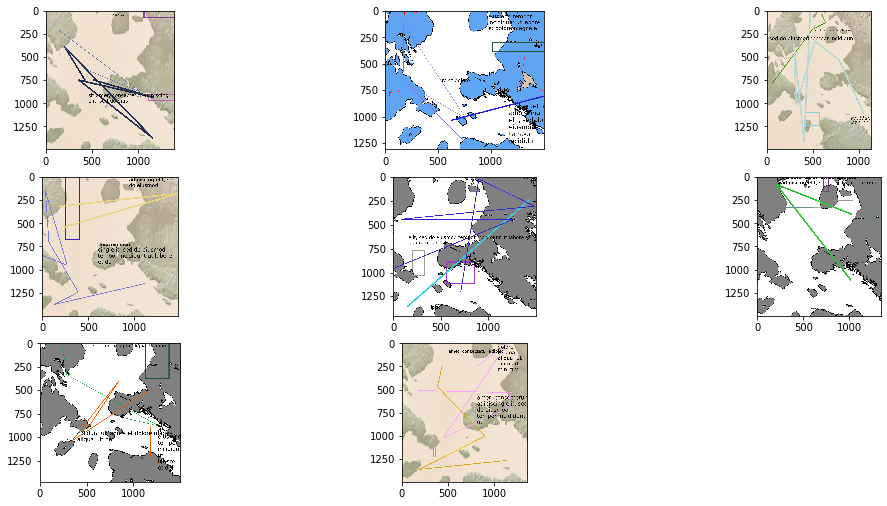

In [26]:
idx = random.randint(0, len(list(feature_dict_image.keys()))-1)
n_images = 8
print('Image number {} and its {}-closest images in the database'.format(idx, n_images-1))
get_similar_item_images(feature_dict_image[list(feature_dict_image.keys())[idx]].flatten(), lsh_images, n_images)